In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from env import get_db_url

In [19]:
pd.options.display.float_format = '{:,.3f}'.format

### Acquire and Summarize

1. Acquire data from the cloud database.

You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.

Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid. - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) - Only include properties that have a latitude and longitude value.

In [12]:
#Create the SQL query
query = '''
        SELECT prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        land.propertylandusedesc,
        story.storydesc,
        type.typeconstructiondesc
        FROM properties_2017 prop
        JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid
            ) pred USING(parcelid)
        JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                          AND pred.max_transactiondate = predictions_2017.transactiondate
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
        '''

In [14]:
import os

In [15]:
def acquire_zillow():
    '''
    acuires data from codeup data base
    returns a pandas dataframe with
    'Single Family Residential' properties of 2017
    from zillow
    '''
    
    filename = 'zillow.csv'

    url = get_db_url('zillow')
    
    # if csv file is available locally, read data from it
    if os.path.isfile(filename):
        df = pd.read_csv(filename) 
    
    # if *.csv file is not available locally, acquire data from SQL database
    # and write it as *.csv for future use
    else:
        # read the SQL query into a dataframe
        df =  pd.read_sql(query, url)
        
        # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename, index_label = False)
        
    return df

In [37]:
df = acquire_zillow()

2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [38]:
df.shape

(52319, 68)

In [39]:
df.columns.tolist()

['id',
 'parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',


In [44]:
for col in df.columns.tolist():
    if col.endswith('id'):
        print(col)
        display(df[col].nunique())
        print()

id


52319


parcelid


52319


airconditioningtypeid


4


architecturalstyletypeid


5


buildingclasstypeid


0


buildingqualitytypeid


12


decktypeid


1


heatingorsystemtypeid


9


propertylandusetypeid


1


storytypeid


1


typeconstructiontypeid


2

In [45]:
df.drop(columns=['id', 'parcelid'], inplace=True)

In [57]:
df.buildingclasstypeid.isna().sum() == df.shape[0]

True

In [58]:
for col in df.columns.tolist():
    if df[col].isna().sum() == df.shape[0]:
        df.drop(columns=col, inplace=True)

In [59]:
df.shape

(52319, 62)

In [60]:
for col in df.columns.tolist():
    if col.endswith('id'):
        print(col)
        display(df[col].value_counts(dropna=False))
        print()

airconditioningtypeid


NaN       38704
1.000     11873
13.000     1567
5.000       159
11.000       16
Name: airconditioningtypeid, dtype: int64


architecturalstyletypeid


NaN       52249
7.000        62
3.000         3
2.000         2
21.000        2
8.000         1
Name: architecturalstyletypeid, dtype: int64


buildingqualitytypeid


NaN       18665
6.000     10260
8.000      8222
4.000      8135
7.000      3424
5.000      1507
9.000      1119
11.000      514
10.000      230
3.000       149
12.000       81
1.000         8
2.000         5
Name: buildingqualitytypeid, dtype: int64


decktypeid


NaN       51930
66.000      389
Name: decktypeid, dtype: int64


heatingorsystemtypeid


2.000     20689
NaN       18470
7.000     12526
6.000       517
20.000       85
13.000       16
1.000         7
18.000        6
10.000        2
24.000        1
Name: heatingorsystemtypeid, dtype: int64


propertylandusetypeid


261.000    52319
Name: propertylandusetypeid, dtype: int64


storytypeid


NaN      52272
7.000       47
Name: storytypeid, dtype: int64


typeconstructiontypeid


NaN      52243
6.000       75
4.000        1
Name: typeconstructiontypeid, dtype: int64

In [63]:
# based on value_counts() i would keep buildingqualitytypeid and heatingorsystemtypeid

# rename those columns to remove id from their name
df.rename({'buildingqualitytypeid':'building_quality_type', 'heatingorsystemtypeid':'heating_system_type'}, 
          inplace=True)

In [130]:
def clean_from_ids(df):
    '''
    the function accepts a dataframe as a parameter
    goes through all columns and removes the ones 
    that end with id
    '''
    #df.drop(columns=['id', 'parcelid'], inplace=True)
    
    # drop the columns that consist only of null values
    for col in df.columns.tolist():
        if df[col].isna().sum() == df.shape[0]:
            df.drop(columns=col, inplace=True)
    # based on value_counts() i would keep buildingqualitytypeid and heatingorsystemtypeid

    # rename those columns to remove id from their name
    df.rename(columns={'buildingqualitytypeid':'building_quality_type', 
                'heatingorsystemtypeid':'heating_system_type'}, inplace=True)
    # remove columns that are  different ids
    columns = []
    for col in df.columns.tolist():
        if col.endswith('id'):
            columns.append(col)
    df.drop(columns=columns, inplace=True)

In [131]:
df = acquire_zillow()

In [132]:
df.shape

(52319, 68)

In [133]:
clean_from_ids(df)

In [134]:
df.shape

(52319, 56)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   basementsqft                  47 non-null     float64
 1   bathroomcnt                   52319 non-null  float64
 2   bedroomcnt                    52319 non-null  float64
 3   building_quality_type         33654 non-null  float64
 4   calculatedbathnbr             52184 non-null  float64
 5   finishedfloor1squarefeet      4371 non-null   float64
 6   calculatedfinishedsquarefeet  52238 non-null  float64
 7   finishedsquarefeet12          52073 non-null  float64
 8   finishedsquarefeet50          4371 non-null   float64
 9   finishedsquarefeet6           165 non-null    float64
 10  fips                          52319 non-null  float64
 11  fireplacecnt                  7233 non-null   float64
 12  fullbathcnt                   52184 non-null  float64
 13  g

In [80]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
basementsqft,47.000,678.979,711.825,38.000,263.500,512.000,809.500,"3,560.000"
bathroomcnt,"52,319.000",2.300,1.023,0.000,2.000,2.000,3.000,18.000
bedroomcnt,"52,319.000",3.301,0.948,0.000,3.000,3.000,4.000,14.000
calculatedbathnbr,"52,184.000",2.305,1.018,1.000,2.000,2.000,3.000,18.000
finishedfloor1squarefeet,"4,371.000","1,546.288",675.339,184.000,"1,151.000","1,410.000","1,760.000","6,912.000"
calculatedfinishedsquarefeet,"52,238.000","1,923.169","1,004.048",128.000,"1,268.000","1,659.000","2,306.000","21,929.000"
finishedsquarefeet12,"52,073.000","1,925.331","1,003.955",128.000,"1,270.000","1,661.000","2,309.000","21,929.000"
finishedsquarefeet50,"4,371.000","1,567.099",745.085,184.000,"1,152.000","1,415.000","1,771.000","12,467.000"
finishedsquarefeet6,165.000,"1,241.079",776.959,380.000,784.000,"1,008.000","1,320.000","5,598.000"
fips,"52,319.000","6,049.136",21.029,"6,037.000","6,037.000","6,037.000","6,059.000","6,111.000"


In [136]:
for col in df.columns:
    print(col)
    display(df[col].value_counts(dropna=False))
    print()

basementsqft


NaN          52272
900.000          2
640.000          2
100.000          2
515.000          2
273.000          2
912.000          2
314.000          1
819.000          1
1,809.000        1
604.000          1
126.000          1
588.000          1
786.000          1
669.000          1
800.000          1
396.000          1
112.000          1
645.000          1
384.000          1
1,969.000        1
252.000          1
600.000          1
1,218.000        1
280.000          1
300.000          1
1,416.000        1
224.000          1
512.000          1
380.000          1
204.000          1
200.000          1
90.000           1
3,112.000        1
405.000          1
1,252.000        1
254.000          1
3,560.000        1
352.000          1
168.000          1
394.000          1
38.000           1
Name: basementsqft, dtype: int64


bathroomcnt


2.000     21839
3.000     10650
1.000      9536
2.500      3932
4.000      2225
3.500       916
1.500       839
5.000       803
4.500       686
6.000       320
5.500       224
0.000       119
7.000        88
8.000        53
6.500        47
7.500        16
9.000        13
10.000        5
11.000        3
8.500         3
18.000        1
13.000        1
Name: bathroomcnt, dtype: int64


bedroomcnt


3.000     23302
4.000     15210
2.000      8317
5.000      3967
6.000       634
1.000       611
0.000       135
7.000       106
8.000        24
9.000         8
10.000        2
14.000        1
11.000        1
12.000        1
Name: bedroomcnt, dtype: int64


building_quality_type


NaN       18665
6.000     10260
8.000      8222
4.000      8135
7.000      3424
5.000      1507
9.000      1119
11.000      514
10.000      230
3.000       149
12.000       81
1.000         8
2.000         5
Name: building_quality_type, dtype: int64


calculatedbathnbr


2.000     21839
3.000     10650
1.000      9536
2.500      3924
4.000      2225
3.500       916
1.500       832
5.000       803
4.500       686
6.000       320
5.500       223
NaN         135
7.000        88
8.000        53
6.500        47
7.500        16
9.000        13
10.000        5
11.000        3
8.500         3
18.000        1
13.000        1
Name: calculatedbathnbr, dtype: int64


finishedfloor1squarefeet


NaN          47948
1,252.000       22
1,205.000       21
1,462.000       21
1,227.000       19
             ...  
1,708.000        1
922.000          1
2,062.000        1
4,300.000        1
2,652.000        1
Name: finishedfloor1squarefeet, Length: 1554, dtype: int64


calculatedfinishedsquarefeet


1,120.000    128
1,200.000    118
1,080.000    101
1,040.000     86
936.000       86
            ... 
9,843.000      1
7,088.000      1
604.000        1
5,422.000      1
5,655.000      1
Name: calculatedfinishedsquarefeet, Length: 4724, dtype: int64


finishedsquarefeet12


NaN          246
1,120.000    127
1,200.000    117
1,080.000    101
936.000       86
            ... 
4,254.000      1
7,003.000      1
490.000        1
6,278.000      1
5,655.000      1
Name: finishedsquarefeet12, Length: 4717, dtype: int64


finishedsquarefeet50


NaN          47948
1,252.000       22
1,205.000       21
1,462.000       21
1,227.000       19
             ...  
1,533.000        1
1,708.000        1
922.000          1
2,062.000        1
2,652.000        1
Name: finishedsquarefeet50, Length: 1573, dtype: int64


finishedsquarefeet6


NaN          52154
952.000          4
520.000          3
750.000          2
845.000          2
             ...  
672.000          1
1,178.000        1
670.000          1
748.000          1
905.000          1
Name: finishedsquarefeet6, Length: 156, dtype: int64


fips


6,037.000    33823
6,059.000    14111
6,111.000     4385
Name: fips, dtype: int64


fireplacecnt


NaN      45086
1.000     6024
2.000      942
3.000      229
4.000       35
5.000        3
Name: fireplacecnt, dtype: int64


fullbathcnt


2.000     25775
3.000     11575
1.000     10368
4.000      2912
5.000      1022
6.000       357
NaN         135
7.000        96
8.000        56
9.000        13
10.000        5
11.000        3
18.000        1
13.000        1
Name: fullbathcnt, dtype: int64


garagecarcnt


NaN       34335
2.000     14777
1.000      2197
3.000       621
4.000       253
0.000        65
5.000        45
6.000        13
7.000         3
10.000        3
8.000         2
9.000         2
11.000        1
13.000        1
14.000        1
Name: garagecarcnt, dtype: int64


garagetotalsqft


NaN          34335
400.000        786
441.000        678
462.000        658
360.000        646
             ...  
1,006.000        1
275.000          1
1,056.000        1
261.000          1
957.000          1
Name: garagetotalsqft, Length: 840, dtype: int64


hashottuborspa


NaN      50805
1.000     1514
Name: hashottuborspa, dtype: int64


heating_system_type


2.000     20689
NaN       18470
7.000     12526
6.000       517
20.000       85
13.000       16
1.000         7
18.000        6
10.000        2
24.000        1
Name: heating_system_type, dtype: int64


latitude


34,047,500.000    12
34,487,900.000     7
33,494,800.000     7
34,101,300.000     7
34,041,200.000     6
                  ..
34,185,350.000     1
34,296,566.000     1
34,077,240.000     1
33,853,596.000     1
33,937,685.000     1
Name: latitude, Length: 50477, dtype: int64


longitude


-118,249,000.000    12
-118,327,000.000     7
-118,172,000.000     7
-117,830,000.000     7
-117,835,000.000     7
                    ..
-118,659,512.000     1
-118,132,169.000     1
-117,744,674.000     1
-118,287,098.000     1
-117,996,709.000     1
Name: longitude, Length: 50763, dtype: int64


lotsizesquarefeet


6,000.000     873
5,000.000     413
NaN           366
7,200.000     306
7,000.000     285
             ... 
26,406.000      1
3,831.000       1
80,148.000      1
21,249.000      1
47,405.000      1
Name: lotsizesquarefeet, Length: 14293, dtype: int64


poolcnt


NaN      41242
1.000    11077
Name: poolcnt, dtype: int64


poolsizesum


NaN          51454
450.000         89
400.000         38
500.000         30
600.000         27
             ...  
275.000          1
434.000          1
1,070.000        1
368.000          1
780.000          1
Name: poolsizesum, Length: 263, dtype: int64


pooltypeid10


NaN      51876
1.000      443
Name: pooltypeid10, dtype: int64


pooltypeid2


NaN      51248
1.000     1071
Name: pooltypeid2, dtype: int64


pooltypeid7


NaN      42329
1.000     9990
Name: pooltypeid7, dtype: int64


propertycountylandusecode


0100    26713
122     13045
0101     6399
1111     3353
1        1066
1110     1024
0104      367
010G       93
0103       91
0108       57
010M       52
0109       18
1112        8
0110        6
0113        6
0141        4
0102        3
0105        3
010V        2
0111        2
0130        2
0131        1
0133        1
0115        1
010L        1
0114        1
Name: propertycountylandusecode, dtype: int64


propertyzoningdesc


NaN           18558
LAR1           6480
LARS           1380
LBR1N          1109
SCUR2           712
              ...  
PDR16OOOO*        1
LRAA6500*         1
POC3*             1
LBPD3             1
BFA15000*         1
Name: propertyzoningdesc, Length: 1287, dtype: int64


rawcensustractandblock


60,379,203.391    36
60,379,201.162    32
60,590,320.571    24
60,371,417.002    24
60,590,320.421    23
                  ..
60,590,746.023     1
60,375,038.014     1
60,375,401.021     1
60,590,992.201     1
60,375,034.021     1
Name: rawcensustractandblock, Length: 31440, dtype: int64


regionidcity


12,447.000    11418
5,534.000      1791
40,227.000     1491
46,298.000     1424
16,764.000     1085
              ...  
32,927.000        3
31,134.000        2
36,078.000        1
10,815.000        1
21,395.000        1
Name: regionidcity, Length: 176, dtype: int64


regionidcounty


3,101.000    33823
1,286.000    14111
2,061.000     4385
Name: regionidcounty, dtype: int64


regionidneighborhood


NaN            33338
48,570.000       501
118,208.000      473
27,080.000       448
274,049.000      391
               ...  
763,079.000        1
764,138.000        1
763,090.000        1
764,167.000        1
762,940.000        1
Name: regionidneighborhood, Length: 438, dtype: int64


regionidzip


97,319.000    776
97,318.000    670
97,329.000    563
97,328.000    519
97,118.000    497
             ... 
96,467.000      1
97,092.000      1
96,148.000      1
96,038.000      1
97,088.000      1
Name: regionidzip, Length: 382, dtype: int64


roomcnt


0.000     37760
6.000      3974
7.000      3608
8.000      2810
5.000      1886
9.000      1173
4.000       518
10.000      338
11.000      108
3.000        79
12.000       35
2.000        12
13.000       10
14.000        6
1.000         1
15.000        1
Name: roomcnt, dtype: int64


threequarterbathnbr


NaN      45602
1.000     6638
2.000       70
3.000        8
7.000        1
Name: threequarterbathnbr, dtype: int64


unitcnt


1.000    33733
NaN      18558
2.000       27
3.000        1
Name: unitcnt, dtype: int64


yardbuildingsqft17


NaN          50384
200.000         85
240.000         71
300.000         49
400.000         37
             ...  
1,176.000        1
538.000          1
1,034.000        1
786.000          1
201.000          1
Name: yardbuildingsqft17, Length: 505, dtype: int64


yardbuildingsqft26


NaN        52256
120.000        3
300.000        2
56.000         2
240.000        2
448.000        2
133.000        1
491.000        1
91.000         1
250.000        1
486.000        1
284.000        1
39.000         1
140.000        1
48.000         1
461.000        1
16.000         1
195.000        1
71.000         1
204.000        1
105.000        1
292.000        1
231.000        1
30.000         1
320.000        1
384.000        1
180.000        1
49.000         1
868.000        1
462.000        1
28.000         1
368.000        1
37.000         1
196.000        1
88.000         1
160.000        1
45.000         1
752.000        1
169.000        1
21.000         1
200.000        1
113.000        1
41.000         1
314.000        1
12.000         1
414.000        1
66.000         1
648.000        1
174.000        1
218.000        1
60.000         1
336.000        1
108.000        1
144.000        1
216.000        1
360.000        1
72.000         1
576.000        1
Name: yardbuil


yearbuilt


1,955.000    1893
1,950.000    1605
1,954.000    1513
1,953.000    1481
1,956.000    1384
             ... 
1,892.000       1
1,878.000       1
1,882.000       1
1,894.000       1
1,880.000       1
Name: yearbuilt, Length: 134, dtype: int64


numberofstories


NaN      37787
1.000     8868
2.000     5312
3.000      351
6.000        1
Name: numberofstories, dtype: int64


fireplaceflag


NaN      52238
1.000       81
Name: fireplaceflag, dtype: int64


structuretaxvaluedollarcnt


NaN            82
100,000.000    50
200,000.000    36
90,000.000     32
32,489.000     28
               ..
126,635.000     1
156,624.000     1
76,353.000      1
68,884.000      1
32,797.000      1
Name: structuretaxvaluedollarcnt, Length: 37333, dtype: int64


taxvaluedollarcnt


455,000.000      33
600,000.000      30
500,000.000      24
450,000.000      24
550,000.000      24
                 ..
2,440,391.000     1
690,763.000       1
379,764.000       1
317,155.000       1
49,546.000        1
Name: taxvaluedollarcnt, Length: 38942, dtype: int64


assessmentyear


2,016.000    52319
Name: assessmentyear, dtype: int64


landtaxvaluedollarcnt


21,299.000     95
30,210.000     63
22,755.000     63
16,522.000     53
16,749.000     51
               ..
86,973.000      1
499,170.000     1
250,803.000     1
122,033.000     1
283,704.000     1
Name: landtaxvaluedollarcnt, Length: 36913, dtype: int64


taxamount


NaN          4
345.720      4
5,170.360    3
7,210.680    3
5,061.140    3
            ..
6,526.810    1
2,821.200    1
4,626.400    1
6,233.120    1
6,317.150    1
Name: taxamount, Length: 50834, dtype: int64


taxdelinquencyflag


NaN    50251
Y       2068
Name: taxdelinquencyflag, dtype: int64


taxdelinquencyyear


NaN       50251
15.000     1124
14.000      559
13.000      126
12.000       81
11.000       79
10.000       47
9.000        33
8.000         8
7.000         8
6.000         1
99.000        1
4.000         1
Name: taxdelinquencyyear, dtype: int64


censustractandblock


NaN                       121
60,379,201,162,006.000     32
60,379,203,391,054.000     27
60,590,320,571,003.000     24
60,371,417,002,000.000     24
                         ... 
60,374,604,011,023.000      1
60,373,006,005,006.000      1
60,590,997,011,004.000      1
60,373,019,003,000.000      1
60,375,034,021,020.000      1
Name: censustractandblock, Length: 31405, dtype: int64


logerror


0.003     5
0.000     5
0.001     5
0.002     5
0.001     4
         ..
0.093     1
-0.050    1
-0.112    1
0.076     1
0.037     1
Name: logerror, Length: 52060, dtype: int64


transactiondate


2017-06-30    809
2017-04-28    614
2017-05-31    565
2017-07-28    546
2017-08-31    528
             ... 
2017-05-07      1
2017-05-13      1
2017-05-20      1
2017-06-11      1
2017-09-25      1
Name: transactiondate, Length: 257, dtype: int64


airconditioningdesc


NaN          38704
Central      11873
Yes           1567
None           159
Wall Unit       16
Name: airconditioningdesc, dtype: int64


architecturalstyledesc


NaN              52249
Contemporary        62
Cape Cod             3
Bungalow             2
Ranch/Rambler        2
Conventional         1
Name: architecturalstyledesc, dtype: int64


heatingorsystemdesc


Central       20689
NaN           18470
Floor/Wall    12526
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64


propertylandusedesc


Single Family Residential    52319
Name: propertylandusedesc, dtype: int64


storydesc


NaN         52272
Basement       47
Name: storydesc, dtype: int64


typeconstructiondesc


NaN         52243
Frame          75
Concrete        1
Name: typeconstructiondesc, dtype: int64

In [110]:
df.columns

Index(['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet50', 'finishedsquarefeet6',
       'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt',
       'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10',
       'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactionda

In [139]:
# potentially to be dropped because of the high # of NaN values:
# finishedfloor1squarefeet, finishedsquarefeet50, finishedsquarefeet6, poolsizesum, propertyzoningdesc
# yardbuildingsqft17, yardbuildingsqft26, fireplaceflag, taxdelinquencyflag, airconditioningdesc
# architecturalstyledesc, storydesc, typeconstructiondesc

# replace NaN with zeros
df.basementsqft = df.basementsqft.fillna(0)
df.fireplacecnt = df.fireplacecnt.fillna(0)
df.fullbathcnt = df.fullbathcnt.fillna(0)
df.garagecarcnt = df.garagecarcnt.fillna(0)
df.garagetotalsqft = df.garagetotalsqft.fillna(0)
df.hashottuborspa = df.hashottuborspa.fillna(0)
df.poolcnt = df.poolcnt.fillna(0)
df.pooltypeid10 = df.pooltypeid10.fillna(0)
df.pooltypeid2 = df.pooltypeid2.fillna(0)
df.pooltypeid7 = df.pooltypeid7.fillna(0)
df.unitcnt = df.unitcnt.fillna(0)
df.heatingorsystemdesc = df.heatingorsystemdesc.fillna('None')

df.rename(columns={'basementsqft':'basement_sqft', 
           'calculatedfinishedsquarefeet':'sqft',
           'fireplacecnt':'fireplace', 
           'fullbathcnt':'fullbath',
           'garagecarcnt':'garage',
           'garagetotalsqft':'garage_sqft',
           'hashottuborspa':'hottub_spa',
           'lotsizesquarefeet': 'lot_sqft',
           'poolcnt':'pool',
           'pooltypeid10':'pool_10',
           'pooltypeid2':'pool_2',
           'pooltypeid7':'pool_7',
           'propertycountylandusecode':'county_land_code',
           'unitcnt':'unit',
           'yearbuilt':'year_built',
           'structuretaxvaluedollarcnt':'structure_price',
           'taxvaluedollarcnt':'price',
           'landtaxvaluedollarcnt':'land_price',
           'taxamount':'tax_amount',
           'heatingorsystemdesc':'heating_system'
          }, inplace=True)

# too many  or 1 categorical unique values
df.drop(columns=['rawcensustractandblock', 'regionidcity', 'regionidneighborhood', 
                 'censustractandblock', 'assessmentyear', 'transactiondate',
                'propertylandusedesc'], 
        inplace=True)

In [141]:
df.shape

(52319, 49)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   basement_sqft             52319 non-null  float64
 1   bathroomcnt               52319 non-null  float64
 2   bedroomcnt                52319 non-null  float64
 3   building_quality_type     33654 non-null  float64
 4   calculatedbathnbr         52184 non-null  float64
 5   finishedfloor1squarefeet  4371 non-null   float64
 6   sqft                      52238 non-null  float64
 7   finishedsquarefeet12      52073 non-null  float64
 8   finishedsquarefeet50      4371 non-null   float64
 9   finishedsquarefeet6       165 non-null    float64
 10  fips                      52319 non-null  float64
 11  fireplace                 52319 non-null  float64
 12  fullbath                  52319 non-null  float64
 13  garage                    52319 non-null  float64
 14  garage

In [142]:
df.heating_system.value_counts()

Central       20689
None          18486
Floor/Wall    12526
Forced air      517
Solar            85
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heating_system, dtype: int64

In [144]:
df.heating_system_type.value_counts(dropna=False)

2.000     20689
NaN       18470
7.000     12526
6.000       517
20.000       85
13.000       16
1.000         7
18.000        6
10.000        2
24.000        1
Name: heating_system_type, dtype: int64

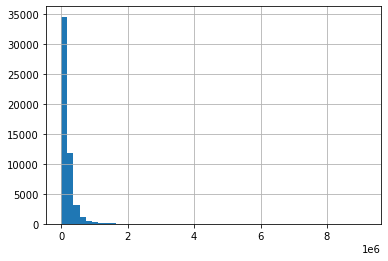

In [101]:
df.structuretaxvaluedollarcnt.hist(bins=50);

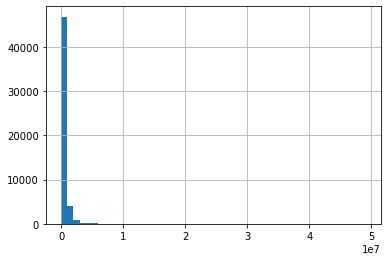

In [102]:
df.taxvaluedollarcnt.hist(bins=50);

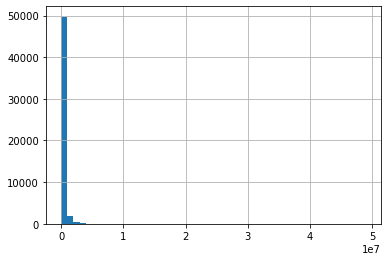

In [103]:
df.landtaxvaluedollarcnt.hist(bins=50);

In [104]:
df.landtaxvaluedollarcnt.isna().sum()

1

In [89]:
# count pooltypeids
9990 + 1071 + 443

11504

In [97]:
df.structuretaxvaluedollarcnt.isnull().sum()

82

In [94]:
df.rawcensustractandblock.max() - df.rawcensustractandblock.min()

739079.9010270014

In [88]:
(df.lotsizesquarefeet == 0).sum()

0

3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [145]:
def null_counter(df):
    new_columns = ['name', 'num_rows_missing', 'pct_rows_missing']
    new_df = pd.DataFrame(columns=new_columns)
    for i, col in enumerate(list(df.columns)):
        num_missing = df[col].isna().sum()
        pct_missing = num_missing / df.shape[0]
        
        new_df.loc[i] = [col, num_missing, pct_missing]
    
    return new_df

In [146]:
null_counter(df)

,name,num_rows_missing,pct_rows_missing
0,basement_sqft,0,0.000
1,bathroomcnt,0,0.000
2,bedroomcnt,0,0.000
3,building_quality_type,18665,0.357
4,calculatedbathnbr,135,0.003
5,finishedfloor1squarefeet,47948,0.916
6,sqft,81,0.002
7,finishedsquarefeet12,246,0.005
8,finishedsquarefeet50,47948,0.916
9,finishedsquarefeet6,52154,0.997


In [2]:
new_columns = ['name', 'num_rows_missing', 'pct_rows_missing']
new_df = pd.DataFrame(columns=new_columns)

In [3]:
new_df

,name,num_rows_missing,pct_rows_missing


In [5]:
new_df.loc[0] = ['hi', 33, 0.45]

In [6]:
new_df

,name,num_rows_missing,pct_rows_missing
0,hi,33,0.45


In [7]:
new_df.loc[1] = ['by', 23, 0.96]

In [8]:
new_df

,name,num_rows_missing,pct_rows_missing
0,hi,33,0.45
1,by,23,0.96


In [9]:
new_df.loc['hello'] = ['hello', 3, 0.2]

In [10]:
new_df

,name,num_rows_missing,pct_rows_missing
0,hi,33,0.45
1,by,23,0.96
hello,hello,3,0.20


In [ ]:
new_df.loc[name] = [name, num_rows_missing, pct_rows_missing]

In [149]:
#Define function to drop columns/rows based on proportion of nulls
def drop_nulls(df, prop_required_column, prop_required_row):
    
    prop_null_column = 1 - prop_required_column
    
    for col in list(df.columns):
        
        null_sum = df[col].isna().sum()
        null_pct = null_sum / df.shape[0]
        
        if null_pct > prop_null_column:
            df.drop(columns=col, inplace=True)
            
    row_threshold = int(prop_required_row * df.shape[1])
    
    df.dropna(axis=0, thresh=row_threshold, inplace=True)

In [150]:
drop_nulls(df, 0.75, 0.75)

In [151]:
df.shape

(52319, 31)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   basement_sqft         52319 non-null  float64
 1   bathroomcnt           52319 non-null  float64
 2   bedroomcnt            52319 non-null  float64
 3   calculatedbathnbr     52184 non-null  float64
 4   sqft                  52238 non-null  float64
 5   finishedsquarefeet12  52073 non-null  float64
 6   fips                  52319 non-null  float64
 7   fireplace             52319 non-null  float64
 8   fullbath              52319 non-null  float64
 9   garage                52319 non-null  float64
 10  garage_sqft           52319 non-null  float64
 11  hottub_spa            52319 non-null  float64
 12  latitude              52319 non-null  float64
 13  longitude             52319 non-null  float64
 14  lot_sqft              51953 non-null  float64
 15  pool               

In [196]:
def print_value_counts(df):
    for col in df.columns.tolist():
        print(col)
        display(df[col].value_counts(dropna=False).reset_index())
        print()

In [159]:
df.shape

(52319, 31)

In [160]:
df = df.dropna(axis=0)

In [161]:
df.isnull().sum()

basement_sqft           0
bathroomcnt             0
bedroomcnt              0
calculatedbathnbr       0
sqft                    0
finishedsquarefeet12    0
fips                    0
fireplace               0
fullbath                0
garage                  0
garage_sqft             0
hottub_spa              0
latitude                0
longitude               0
lot_sqft                0
pool                    0
pool_10                 0
pool_2                  0
pool_7                  0
county_land_code        0
regionidcounty          0
regionidzip             0
roomcnt                 0
unit                    0
year_built              0
structure_price         0
price                   0
land_price              0
tax_amount              0
logerror                0
heating_system          0
dtype: int64

In [162]:
df.shape

(51577, 31)

In [164]:
df[['sqft', 'finishedsquarefeet12']] #looks identical

,sqft,finishedsquarefeet12
0,"3,100.000","3,100.000"
1,"1,465.000","1,465.000"
2,"1,243.000","1,243.000"
3,"2,376.000","2,376.000"
4,"2,962.000","2,962.000"
...,...,...
52314,"1,633.000","1,633.000"
52315,"1,286.000","1,286.000"
52316,"1,612.000","1,612.000"
52317,"1,032.000","1,032.000"


In [166]:
(df.sqft != df.finishedsquarefeet12).sum()

0

In [ ]:
# finishedsquarefeet12 is safe to drop, add to drops in wrangle file

In [168]:
df[['pool', 'pool_10', 'pool_2', 'pool_7']]

,pool,pool_10,pool_2,pool_7
0,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000
2,1.000,0.000,0.000,1.000
3,1.000,0.000,0.000,1.000
4,1.000,0.000,0.000,1.000
...,...,...,...,...
52314,0.000,0.000,0.000,0.000
52315,0.000,0.000,0.000,0.000
52316,0.000,0.000,0.000,0.000
52317,0.000,0.000,0.000,0.000


In [171]:
(df.pool != (df.pool_10 + df.pool_2 + df.pool_7)).sum()

459

In [176]:
check_pools = df[df.pool != (df.pool_10 + df.pool_2 + df.pool_7)].loc[:, ['pool', 'pool_10', 'pool_2', 'pool_7']]

In [182]:
check_pools[check_pools.pool_7 == 1]

,pool,pool_10,pool_2,pool_7


In [186]:
df.pool = np.where((df.pool == 0) & (df.pool_10 == 1), 1, df.pool)

In [188]:
df[(df.pool == 0) & (df.pool_10 == 1)]

,basement_sqft,bathroomcnt,bedroomcnt,calculatedbathnbr,sqft,finishedsquarefeet12,fips,fireplace,fullbath,garage,...,regionidzip,roomcnt,unit,year_built,structure_price,price,land_price,tax_amount,logerror,heating_system


In [189]:
df.pool.unique()

array([0., 1.])

In [190]:
#index	pool
#0	0.000	40601
#1	1.000	10976
df.pool.value_counts()

0.000    40158
1.000    11419
Name: pool, dtype: int64

In [193]:
# now all pool_2(7, 10) can be dropped
df.drop(columns=['pool_10', 'pool_2', 'pool_7'], inplace=True) # add to wrangle file

In [194]:
df.shape

(51577, 28)

In [195]:
df.columns

Index(['basement_sqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'sqft', 'finishedsquarefeet12', 'fips', 'fireplace', 'fullbath',
       'garage', 'garage_sqft', 'hottub_spa', 'latitude', 'longitude',
       'lot_sqft', 'pool', 'county_land_code', 'regionidcounty', 'regionidzip',
       'roomcnt', 'unit', 'year_built', 'structure_price', 'price',
       'land_price', 'tax_amount', 'logerror', 'heating_system'],
      dtype='object')

In [198]:
numerical_columns = ['calculatedbathnbr','sqft', 'garage_sqft', 'latitude', 'longitude', 'lot_sqft', 'year_built',
                    'structure_price', 'price', 'land_price', 'tax_amount', 'logerror']

In [197]:
print_value_counts(df)

basement_sqft


,index,basement_sqft
0,0.000,51530
1,900.000,2
2,640.000,2
3,100.000,2
4,515.000,2
5,273.000,2
6,912.000,2
7,314.000,1
8,819.000,1
9,"1,809.000",1



bathroomcnt


,index,bathroomcnt
0,2.000,21714
1,3.000,10524
2,1.000,9339
3,2.500,3917
4,4.000,2151
5,3.500,909
6,1.500,824
7,5.000,771
8,4.500,681
9,6.000,300



bedroomcnt


,index,bedroomcnt
0,3.000,23126
1,4.000,15055
2,2.000,8160
3,5.000,3903
4,6.000,624
5,1.000,545
6,7.000,102
7,0.000,27
8,8.000,24
9,9.000,8



calculatedbathnbr


,index,calculatedbathnbr
0,2.000,21714
1,3.000,10524
2,1.000,9339
3,2.500,3917
4,4.000,2151
5,3.500,909
6,1.500,824
7,5.000,771
8,4.500,681
9,6.000,300



sqft


,index,sqft
0,"1,120.000",127
1,"1,200.000",116
2,"1,080.000",101
3,936.000,86
4,"1,176.000",83
...,...,...
4677,"5,481.000",1
4678,"4,065.000",1
4679,"7,812.000",1
4680,"7,356.000",1



finishedsquarefeet12


,index,finishedsquarefeet12
0,"1,120.000",127
1,"1,200.000",116
2,"1,080.000",101
3,936.000,86
4,"1,176.000",83
...,...,...
4677,"5,481.000",1
4678,"4,065.000",1
4679,"7,812.000",1
4680,"7,356.000",1



fips


,index,fips
0,"6,037.000",33406
1,"6,059.000",13840
2,"6,111.000",4331



fireplace


,index,fireplace
0,0.000,44410
1,1.000,5976
2,2.000,930
3,3.000,224
4,4.000,34
5,5.000,3



fullbath


,index,fullbath
0,2.000,25643
1,3.000,11442
2,1.000,10163
3,4.000,2833
4,5.000,990
5,6.000,337
6,7.000,95
7,8.000,53
8,9.000,12
9,10.000,5



garage


,index,garage
0,0.000,33747
1,2.000,14739
2,1.000,2154
3,3.000,617
4,4.000,250
5,5.000,45
6,6.000,12
7,7.000,3
8,10.000,3
9,8.000,2



garage_sqft


,index,garage_sqft
0,0.000,33875
1,400.000,783
2,441.000,676
3,462.000,657
4,360.000,645
...,...,...
830,"1,090.000",1
831,"1,296.000",1
832,221.000,1
833,301.000,1



hottub_spa


,index,hottub_spa
0,0.000,50063
1,1.000,1514



latitude


,index,latitude
0,"34,101,300.000",7
1,"34,487,900.000",7
2,"34,041,200.000",6
3,"33,765,800.000",5
4,"33,865,295.000",4
...,...,...
49826,"33,800,972.000",1
49827,"34,639,548.000",1
49828,"34,122,431.000",1
49829,"34,216,351.000",1



longitude


,index,longitude
0,"-118,327,000.000",7
1,"-117,835,000.000",7
2,"-118,172,000.000",7
3,"-118,251,000.000",6
4,"-117,847,000.000",5
...,...,...
50108,"-118,287,098.000",1
50109,"-118,211,348.000",1
50110,"-118,459,027.000",1
50111,"-118,947,816.000",1



lot_sqft


,index,lot_sqft
0,"6,000.000",873
1,"5,000.000",413
2,"7,200.000",306
3,"7,000.000",283
4,"6,500.000",270
...,...,...
14172,"16,781.000",1
14173,"20,038.000",1
14174,"24,886.000",1
14175,"2,527.000",1



pool


,index,pool
0,0.000,40158
1,1.000,11419



county_land_code


,index,county_land_code
0,0100,26399
1,122,12802
2,0101,6342
3,1111,3344
4,1,1038
5,1110,986
6,0104,364
7,0103,86
8,010G,78
9,0108,54



regionidcounty


,index,regionidcounty
0,"3,101.000",33406
1,"1,286.000",13840
2,"2,061.000",4331



regionidzip


,index,regionidzip
0,"97,319.000",763
1,"97,318.000",660
2,"97,329.000",563
3,"97,328.000",517
4,"97,118.000",495
...,...,...
374,"95,996.000",2
375,"97,092.000",1
376,"96,038.000",1
377,"96,148.000",1



roomcnt


,index,roomcnt
0,0.000,37265
1,6.000,3934
2,7.000,3585
3,8.000,2795
4,5.000,1833
5,9.000,1165
6,4.000,458
7,10.000,337
8,11.000,103
9,3.000,45



unit


,index,unit
0,1.000,33349
1,0.000,18208
2,2.000,19
3,3.000,1



year_built


,index,year_built
0,"1,955.000",1883
1,"1,950.000",1592
2,"1,954.000",1503
3,"1,953.000",1473
4,"1,956.000",1373
...,...,...
128,"1,892.000",1
129,"1,878.000",1
130,"1,882.000",1
131,"1,894.000",1



structure_price


,index,structure_price
0,"100,000.000",49
1,"200,000.000",36
2,"90,000.000",32
3,"32,489.000",28
4,"95,000.000",26
...,...,...
36873,"236,159.000",1
36874,"94,473.000",1
36875,"39,537.000",1
36876,"80,135.000",1



price


,index,price
0,"455,000.000",33
1,"600,000.000",30
2,"500,000.000",24
3,"550,000.000",24
4,"450,000.000",24
...,...,...
38425,"227,910.000",1
38426,"197,634.000",1
38427,"795,553.000",1
38428,"814,650.000",1



land_price


,index,land_price
0,"21,299.000",95
1,"22,755.000",63
2,"30,210.000",63
3,"16,522.000",53
4,"16,749.000",51
...,...,...
36399,"208,508.000",1
36400,"278,369.000",1
36401,"43,395.000",1
36402,"20,493.000",1



tax_amount


,index,tax_amount
0,345.720,4
1,"1,066.070",3
2,"2,217.310",3
3,"4,386.160",3
4,"1,625.610",3
...,...,...
50117,"2,005.990",1
50118,"4,858.720",1
50119,"1,549.240",1
50120,"8,172.430",1



logerror


,index,logerror
0,0.003,5
1,0.002,5
2,0.001,5
3,0.000,5
4,0.003,4
...,...,...
51317,0.036,1
51318,0.009,1
51319,-0.152,1
51320,0.109,1



heating_system


,index,heating_system
0,Central,20410
1,None,18135
2,Floor/Wall,12445
3,Forced air,510
4,Solar,63
5,Baseboard,7
6,Radiant,4
7,Gravity,2
8,Yes,1


In [199]:
for col in df.columns:
    if col not in numerical_columns:
        df[col] = pd.Categorical(df[col])

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51577 entries, 0 to 52318
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   basement_sqft         51577 non-null  category
 1   bathroomcnt           51577 non-null  category
 2   bedroomcnt            51577 non-null  category
 3   calculatedbathnbr     51577 non-null  float64 
 4   sqft                  51577 non-null  float64 
 5   finishedsquarefeet12  51577 non-null  category
 6   fips                  51577 non-null  category
 7   fireplace             51577 non-null  category
 8   fullbath              51577 non-null  category
 9   garage                51577 non-null  category
 10  garage_sqft           51577 non-null  float64 
 11  hottub_spa            51577 non-null  category
 12  latitude              51577 non-null  float64 
 13  longitude             51577 non-null  float64 
 14  lot_sqft              51577 non-null  float64 
 15  po

In [226]:
df = acquire_zillow()

In [220]:
from importlib import reload

In [227]:
import wrangle_zillow as wz

In [228]:
reload(wz)

<module 'wrangle_zillow' from '/Users/nadina/codeup-data-science/clustering-exercises/wrangle_zillow.py'>

In [229]:
wz.clean_from_ids(df)

In [230]:
df.shape

(52319, 56)

In [232]:
wz.fill_nulls(df)

In [233]:
df.shape

(52319, 47)

In [235]:
wz.drop_nulls(df)

In [236]:
df.shape

(52319, 26)

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bath               52319 non-null  float64
 1   beds               52319 non-null  float64
 2   calculatedbathnbr  52184 non-null  float64
 3   sqft               52238 non-null  float64
 4   fips               52319 non-null  float64
 5   fireplace          52319 non-null  float64
 6   fullbath           52319 non-null  float64
 7   garage             52319 non-null  float64
 8   garage_sqft        52319 non-null  float64
 9   hottub_spa         52319 non-null  float64
 10  latitude           52319 non-null  float64
 11  longitude          52319 non-null  float64
 12  lot_sqft           51953 non-null  float64
 13  pool               52319 non-null  float64
 14  county_land_code   52319 non-null  object 
 15  regionidcounty     52319 non-null  float64
 16  regionidzip        522

In [240]:
df.isnull().sum()

bath                   0
beds                   0
calculatedbathnbr    135
sqft                  81
fips                   0
fireplace              0
fullbath               0
garage                 0
garage_sqft            0
hottub_spa             0
latitude               0
longitude              0
lot_sqft             366
pool                   0
county_land_code       0
regionidcounty         0
regionidzip           26
roomcnt                0
unit                   0
year_built           114
structure_price       82
price                  1
land_price             1
tax_amount             4
logerror               0
heating_system         0
dtype: int64

In [241]:
df.iloc[:, :3]

,bath,beds,calculatedbathnbr
0,3.500,4.000,3.500
1,1.000,2.000,1.000
2,2.000,3.000,2.000
3,3.000,4.000,3.000
4,3.000,4.000,3.000
...,...,...,...
52314,2.000,4.000,2.000
52315,2.000,2.000,2.000
52316,2.000,4.000,2.000
52317,1.000,3.000,1.000


In [242]:
(df.bath != df.calculatedbathnbr).sum()

135

In [244]:
df[df.bath != df.calculatedbathnbr].calculatedbathnbr.unique()

array([nan])

In [ ]:
# calculatedbathnbr is safe to drop

In [245]:
# reload and start again
df = acquire_zillow()

In [246]:
reload(wz)

<module 'wrangle_zillow' from '/Users/nadina/codeup-data-science/clustering-exercises/wrangle_zillow.py'>

In [247]:
def reload_zillow():
    df = acquire_zillow()
    wz.clean_from_ids(df)
    wz.fill_nulls(df)
    wz.drop_nulls(df)
    return df

In [254]:
df = reload_zillow()

In [255]:
df.shape

(52319, 25)

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bath              52319 non-null  float64
 1   beds              52319 non-null  float64
 2   sqft              52238 non-null  float64
 3   fips              52319 non-null  float64
 4   fireplace         52319 non-null  float64
 5   fullbath          52319 non-null  float64
 6   garage            52319 non-null  float64
 7   garage_sqft       52319 non-null  float64
 8   hottub_spa        52319 non-null  float64
 9   latitude          52319 non-null  float64
 10  longitude         52319 non-null  float64
 11  lot_sqft          51953 non-null  float64
 12  pool              52319 non-null  float64
 13  county_land_code  52319 non-null  object 
 14  regionidcounty    52319 non-null  float64
 15  regionidzip       52293 non-null  float64
 16  roomcnt           52319 non-null  float6

In [259]:
(df.bath == 0).sum()

119

In [276]:
wz.print_value_counts(df)

bath


,index,bath
0,2.000,21735
1,3.000,10523
2,1.000,9431
3,2.500,3924
4,4.000,2153
5,3.500,909
6,1.500,830
7,5.000,770
8,4.500,681
9,6.000,300



beds


,index,beds
0,3.000,23167
1,4.000,15067
2,2.000,8227
3,5.000,3908
4,6.000,626
5,1.000,572
6,7.000,102
7,8.000,24
8,9.000,8
9,10.000,2



sqft


,index,sqft
0,"1,120.000",127
1,"1,200.000",117
2,"1,080.000",101
3,936.000,86
4,"1,176.000",83
...,...,...
4678,"9,059.000",1
4679,"5,104.000",1
4680,"5,481.000",1
4681,"4,065.000",1



fips


,index,fips
0,"6,037.000",33383
1,"6,059.000",13995
2,"6,111.000",4326



fireplace


,index,fireplace
0,0.000,44516
1,1.000,5995
2,2.000,931
3,3.000,225
4,4.000,34
5,5.000,3



fullbath


,index,fullbath
0,2.000,25663
1,3.000,11441
2,1.000,10255
3,4.000,2835
4,5.000,989
5,6.000,337
6,7.000,95
7,8.000,53
8,0.000,15
9,9.000,12



garage


,index,garage
0,0.000,33877
1,2.000,14735
2,1.000,2155
3,3.000,617
4,4.000,250
5,5.000,45
6,6.000,12
7,7.000,3
8,10.000,3
9,8.000,2



garage_sqft


,index,garage_sqft
0,0.000,34005
1,400.000,783
2,441.000,676
3,462.000,657
4,360.000,645
...,...,...
830,"1,090.000",1
831,"1,296.000",1
832,221.000,1
833,301.000,1



hottub_spa


,index,hottub_spa
0,0.000,50190
1,1.000,1514



latitude


,index,latitude
0,"34,487,900.000",7
1,"34,041,200.000",5
2,"33,765,800.000",5
3,"33,832,996.000",4
4,"34,083,489.000",4
...,...,...
49959,"33,898,442.000",1
49960,"34,176,035.000",1
49961,"34,716,913.000",1
49962,"33,822,296.000",1



longitude


,index,longitude
0,"-117,835,000.000",7
1,"-118,172,000.000",7
2,"-117,874,000.000",5
3,"-118,251,000.000",5
4,"-118,364,216.000",5
...,...,...
50238,"-118,132,169.000",1
50239,"-117,744,674.000",1
50240,"-118,287,098.000",1
50241,"-118,211,348.000",1



lot_sqft


,index,lot_sqft
0,"6,000.000",873
1,"5,000.000",413
2,"7,200.000",306
3,"7,000.000",283
4,"6,500.000",270
...,...,...
14202,"15,547.000",1
14203,"27,500.000",1
14204,"15,333.000",1
14205,"17,987.000",1



pool


,index,pool
0,0.000,40278
1,1.000,11426



county_land_code


,index,county_land_code
0,0100,26393
1,122,12956
2,0101,6341
3,1111,3341
4,1,1039
5,1110,984
6,0104,364
7,0103,86
8,010G,63
9,0108,54



regionidcounty


,index,regionidcounty
0,"3,101.000",33383
1,"1,286.000",13995
2,"2,061.000",4326



regionidzip


,index,regionidzip
0,"97,319.000",763
1,"97,318.000",660
2,"97,329.000",563
3,"97,328.000",517
4,"97,118.000",495
...,...,...
373,"96,039.000",2
374,"96,038.000",1
375,"96,148.000",1
376,"97,092.000",1



roomcnt


,index,roomcnt
0,0.000,37239
1,6.000,3964
2,7.000,3595
3,8.000,2802
4,5.000,1869
5,9.000,1168
6,4.000,498
7,10.000,338
8,11.000,105
9,3.000,68



unit


,index,unit
0,1.000,33329
1,0.000,18355
2,2.000,19
3,3.000,1



year_built


,index,year_built
0,"1,955.000",1886
1,"1,950.000",1598
2,"1,954.000",1506
3,"1,953.000",1477
4,"1,956.000",1375
...,...,...
128,"1,892.000",1
129,"1,878.000",1
130,"1,882.000",1
131,"1,894.000",1



structure_price


,index,structure_price
0,"100,000.000",49
1,"200,000.000",36
2,"90,000.000",32
3,"32,489.000",28
4,"95,000.000",26
...,...,...
36974,"236,159.000",1
36975,"94,473.000",1
36976,"39,537.000",1
36977,"80,135.000",1



price


,index,price
0,"455,000.000",33
1,"600,000.000",30
2,"450,000.000",24
3,"500,000.000",24
4,"550,000.000",24
...,...,...
38516,"844,420.000",1
38517,"120,595.000",1
38518,"208,572.000",1
38519,"116,909.000",1



land_price


,index,land_price
0,"21,299.000",95
1,"30,210.000",63
2,"22,755.000",63
3,"16,522.000",53
4,"16,749.000",51
...,...,...
36523,"86,973.000",1
36524,"499,170.000",1
36525,"250,803.000",1
36526,"122,033.000",1



tax_amount


,index,tax_amount
0,345.720,4
1,"4,012.740",3
2,"3,326.620",3
3,"7,210.680",3
4,"5,247.060",3
...,...,...
50241,"1,912.160",1
50242,"2,686.710",1
50243,"4,038.400",1
50244,770.050,1



logerror


,index,logerror
0,0.000,5
1,0.002,5
2,0.003,5
3,0.001,5
4,0.003,4
...,...,...
51444,0.076,1
51445,-0.015,1
51446,-0.001,1
51447,0.007,1



heating_system


,index,heating_system
0,Central,20402
1,None,18271
2,Floor/Wall,12442
3,Forced air,512
4,Solar,63
5,Baseboard,7
6,Radiant,4
7,Gravity,2
8,Yes,1


In [265]:
def handle_outliers(df):
    df = df[df.sqft >= 300]
    df = df[df.bath != 0]
    df = df[df.beds != 0]
    return df

In [266]:
df = handle_outliers(df)

In [267]:
df.shape

(52159, 25)

In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51704 entries, 0 to 52318
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bath              51704 non-null  float64
 1   beds              51704 non-null  float64
 2   sqft              51704 non-null  float64
 3   fips              51704 non-null  float64
 4   fireplace         51704 non-null  float64
 5   fullbath          51704 non-null  float64
 6   garage            51704 non-null  float64
 7   garage_sqft       51704 non-null  float64
 8   hottub_spa        51704 non-null  float64
 9   latitude          51704 non-null  float64
 10  longitude         51704 non-null  float64
 11  lot_sqft          51704 non-null  float64
 12  pool              51704 non-null  float64
 13  county_land_code  51704 non-null  object 
 14  regionidcounty    51704 non-null  float64
 15  regionidzip       51704 non-null  float64
 16  roomcnt           51704 non-null  float6

In [284]:
df[['fips','regionidcounty']]

,fips,regionidcounty
0,"6,059.000","1,286.000"
1,"6,111.000","2,061.000"
2,"6,059.000","1,286.000"
3,"6,037.000","3,101.000"
4,"6,037.000","3,101.000"
...,...,...
52314,"6,037.000","3,101.000"
52315,"6,037.000","3,101.000"
52316,"6,111.000","2,061.000"
52317,"6,037.000","3,101.000"


In [285]:
((df.fips == 6059) & (df.regionidcounty != 1286)).sum()

0

In [286]:
((df.fips == 6111) & (df.regionidcounty != 2061)).sum()

0

In [287]:
((df.fips == 6037) & (df.regionidcounty != 3101)).sum()

0

In [ ]:
# regionidcounty is safe to drop ---> add to wrangle file

In [288]:
df.regionidzip.nunique() # drop, too many categories

378

In [294]:
df.county_land_code.nunique()

22

In [295]:
df.county_land_code.unique()

array(['122', '1110', '0101', '0100', '1111', '0103', '1', '0104', '0108',
       '010G', '0102', '010M', '0109', '0113', '0133', '0131', '0111',
       '0110', '0105', '1112', '0114', '0130'], dtype=object)

In [292]:
reload(wz)
df = reload_zillow()

In [293]:
df.shape

(51781, 23)

In [298]:
for col in df.iloc[:, :-3].columns:
    if df[col].dtype != 'object':
        df[col] = df[col].astype(int)

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51781 entries, 0 to 52318
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bath              51781 non-null  int64  
 1   beds              51781 non-null  int64  
 2   sqft              51781 non-null  int64  
 3   fips              51781 non-null  int64  
 4   fireplace         51781 non-null  int64  
 5   fullbath          51781 non-null  int64  
 6   garage            51781 non-null  int64  
 7   garage_sqft       51781 non-null  int64  
 8   hottub_spa        51781 non-null  int64  
 9   latitude          51781 non-null  int64  
 10  longitude         51781 non-null  int64  
 11  lot_sqft          51781 non-null  int64  
 12  pool              51781 non-null  int64  
 13  county_land_code  51781 non-null  object 
 14  roomcnt           51781 non-null  int64  
 15  unit              51781 non-null  int64  
 16  year_built        51781 non-null  int64 

In [300]:
wz.print_value_counts(df)

bath


,index,bath
0,2,25672
1,3,11439
2,1,10276
3,4,2834
4,5,995
5,6,347
6,7,103
7,8,53
8,0,41
9,9,12



beds


,index,beds
0,3,23177
1,4,15073
2,2,8229
3,5,3910
4,6,626
5,1,575
6,7,102
7,0,54
8,8,24
9,9,8



sqft


,index,sqft
0,1120,128
1,1200,118
2,1080,101
3,936,86
4,1040,83
...,...,...
4688,4783,1
4689,609,1
4690,4716,1
4691,3509,1



fips


,index,fips
0,6037,33430
1,6059,14004
2,6111,4347



fireplace


,index,fireplace
0,0,44579
1,1,6002
2,2,936
3,3,226
4,4,35
5,5,3



fullbath


,index,fullbath
0,2,25676
1,3,11448
2,1,10270
3,4,2835
4,5,990
5,6,337
6,7,95
7,0,56
8,8,53
9,9,12



garage


,index,garage
0,0,33932
1,2,14753
2,1,2157
3,3,618
4,4,251
5,5,45
6,6,12
7,7,3
8,10,3
9,8,2



garage_sqft


,index,garage_sqft
0,0,34062
1,400,784
2,441,676
3,462,657
4,360,645
...,...,...
831,175,1
832,1296,1
833,221,1
834,301,1



hottub_spa


,index,hottub_spa
0,0,50267
1,1,1514



latitude


,index,latitude
0,34487900,7
1,34101300,7
2,34041200,6
3,33765800,5
4,34083489,4
...,...,...
50013,34185350,1
50014,34296566,1
50015,34077240,1
50016,33853596,1



longitude


,index,longitude
0,-118172000,7
1,-118327000,7
2,-117835000,7
3,-118251000,6
4,-118256000,5
...,...,...
50299,-118184391,1
50300,-118226755,1
50301,-119159167,1
50302,-117834737,1



lot_sqft


,index,lot_sqft
0,6000,873
1,5000,413
2,7200,306
3,7000,284
4,6500,270
...,...,...
14221,23363,1
14222,26240,1
14223,19457,1
14224,18942,1



pool


,index,pool
0,0,40342
1,1,11439



county_land_code


,index,county_land_code
0,0100,26415
1,122,12961
2,0101,6342
3,1111,3347
4,1,1043
5,1110,999
6,0104,364
7,0103,86
8,010G,78
9,0108,54



roomcnt


,index,roomcnt
0,0,37297
1,6,3967
2,7,3597
3,8,2806
4,5,1871
5,9,1172
6,4,499
7,10,338
8,11,105
9,3,68



unit


,index,unit
0,1,33368
1,0,18392
2,2,20
3,3,1



year_built


,index,year_built
0,1955,1887
1,1950,1601
2,1954,1506
3,1953,1478
4,1956,1375
...,...,...
128,1892,1
129,1878,1
130,1882,1
131,1894,1



structure_price


,index,structure_price
0,100000,50
1,200000,36
2,90000,32
3,32489,28
4,95000,26
...,...,...
37026,166697,1
37027,126635,1
37028,156624,1
37029,76353,1



price


,index,price
0,455000,33
1,600000,30
2,550000,24
3,500000,24
4,450000,24
...,...,...
38576,1352824,1
38577,135740,1
38578,534542,1
38579,409207,1



land_price


,index,land_price
0,21299,95
1,22755,63
2,30210,63
3,16522,53
4,16749,51
...,...,...
36563,122033,1
36564,19827,1
36565,171985,1
36566,74313,1



tax_amount


,index,tax_amount
0,345.720,4
1,"5,947.260",3
2,"3,326.620",3
3,"5,871.380",3
4,"2,217.310",3
...,...,...
50316,"2,821.200",1
50317,"6,233.120",1
50318,"2,090.590",1
50319,"8,654.150",1



logerror


,index,logerror
0,0.000,5
1,0.003,5
2,0.001,5
3,0.002,5
4,0.008,4
...,...,...
51521,-0.005,1
51522,0.093,1
51523,-0.050,1
51524,-0.112,1



heating_system


,index,heating_system
0,Central,20413
1,None,18328
2,Floor/Wall,12451
3,Forced air,512
4,Solar,63
5,Baseboard,7
6,Radiant,4
7,Gravity,2
8,Yes,1


In [301]:
numerical_columns = ['sqft', 'garage_sqft', 'latitude', 'longitude', 'lot_sqft', 'year_built',
                    'structure_price', 'price', 'land_price', 'tax_amount', 'logerror']
for col in df.columns:
    if col not in numerical_columns:
        df[col] = pd.Categorical(df[col])

In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51781 entries, 0 to 52318
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   bath              51781 non-null  category
 1   beds              51781 non-null  category
 2   sqft              51781 non-null  int64   
 3   fips              51781 non-null  category
 4   fireplace         51781 non-null  category
 5   fullbath          51781 non-null  category
 6   garage            51781 non-null  category
 7   garage_sqft       51781 non-null  int64   
 8   hottub_spa        51781 non-null  category
 9   latitude          51781 non-null  int64   
 10  longitude         51781 non-null  int64   
 11  lot_sqft          51781 non-null  int64   
 12  pool              51781 non-null  category
 13  county_land_code  51781 non-null  category
 14  roomcnt           51781 non-null  category
 15  unit              51781 non-null  category
 16  year_built        5178

In [303]:
def transform_columns(df):
    
    # change floats to ints
    for col in df.iloc[:, :-3].columns:
        if df[col].dtype != 'object':
            df[col] = df[col].astype(int)
    # create a list of numerical columns
    numerical_columns = ['sqft', 'garage_sqft', 'latitude', 'longitude', 'lot_sqft', 'year_built',
                    'structure_price', 'price', 'land_price', 'tax_amount', 'logerror']
    # change not numerical columns to categories
    for col in df.columns:
        if col not in numerical_columns:
            df[col] = pd.Categorical(df[col])
    
    return df

In [304]:
df.shape

(51781, 23)

In [306]:
reload(wz)

<module 'wrangle_zillow' from '/Users/nadina/codeup-data-science/clustering-exercises/wrangle_zillow.py'>

In [307]:
df = wz.get_zillow()

In [308]:
df.shape

(51710, 23)

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51710 entries, 0 to 52318
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   bath              51710 non-null  category
 1   beds              51710 non-null  category
 2   sqft              51710 non-null  int64   
 3   fips              51710 non-null  category
 4   fireplace         51710 non-null  category
 5   fullbath          51710 non-null  category
 6   garage            51710 non-null  category
 7   garage_sqft       51710 non-null  int64   
 8   hottub_spa        51710 non-null  category
 9   latitude          51710 non-null  int64   
 10  longitude         51710 non-null  int64   
 11  lot_sqft          51710 non-null  int64   
 12  pool              51710 non-null  category
 13  county_land_code  51710 non-null  category
 14  roomcnt           51710 non-null  category
 15  unit              51710 non-null  category
 16  year_built        5171

In [310]:
df1 = pd.read_csv('clean_zillow.csv')

In [311]:
df1.shape

(51710, 23)

In [312]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51710 entries, 0 to 52318
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bath              51710 non-null  int64  
 1   beds              51710 non-null  int64  
 2   sqft              51710 non-null  int64  
 3   fips              51710 non-null  int64  
 4   fireplace         51710 non-null  int64  
 5   fullbath          51710 non-null  int64  
 6   garage            51710 non-null  int64  
 7   garage_sqft       51710 non-null  int64  
 8   hottub_spa        51710 non-null  int64  
 9   latitude          51710 non-null  int64  
 10  longitude         51710 non-null  int64  
 11  lot_sqft          51710 non-null  int64  
 12  pool              51710 non-null  int64  
 13  county_land_code  51710 non-null  object 
 14  roomcnt           51710 non-null  int64  
 15  unit              51710 non-null  int64  
 16  year_built        51710 non-null  int64 

In [313]:
df1 = wz.transform_columns(df1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51710 entries, 0 to 52318
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   bath              51710 non-null  category
 1   beds              51710 non-null  category
 2   sqft              51710 non-null  int64   
 3   fips              51710 non-null  category
 4   fireplace         51710 non-null  category
 5   fullbath          51710 non-null  category
 6   garage            51710 non-null  category
 7   garage_sqft       51710 non-null  int64   
 8   hottub_spa        51710 non-null  category
 9   latitude          51710 non-null  int64   
 10  longitude         51710 non-null  int64   
 11  lot_sqft          51710 non-null  int64   
 12  pool              51710 non-null  category
 13  county_land_code  51710 non-null  category
 14  roomcnt           51710 non-null  category
 15  unit              51710 non-null  category
 16  year_built        5171